# XYLELLA SIMULATION

In [1]:
# IMPORTS

from GridClass import *
from scipy.optimize import least_squares
from scipy.optimize import minimize

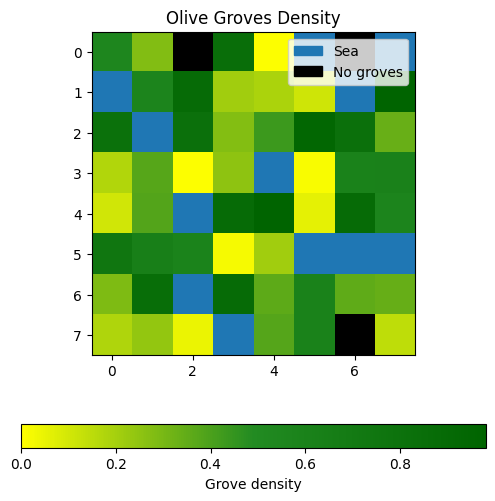

In [2]:
np.random.seed(100)

# GRID INSTANCE INITIALIZATION PARAMETERS
FROM_FILE = False
ROWS = 8 # Random grid
COLS = 8 # Random grid

# CREATE OLIVE GROVE DENSITY, FROM FILE OR RANDOMLY GENERATED
if FROM_FILE:
    file_path = "olivegrowthprop.mat"
    mat = sp.io.loadmat(file_path)
    GRID = Grid(density=mat["olivegrowthprop"])

else:
    GRID = Grid(shape=(ROWS, COLS))

# PLOT DISTRIBUTION OF OLIVE GROVES
GRID.plot_density(figsize=(6,6))

In [3]:
# SIMULATION PARAMETERS
# Control zone parameters
control = False
EZW = 10
BZW = 20
EZ_eff = 1
BZ_eff = 0.9

# Common parameters
A = 3 # 3 kp rate of local population growth
B = 14.069
a = 0 # relative carrying capacity in non olive plants
tol = 1e-8 # 1e-8 numerical noise tolerance (IF TOLERANCE IS TOO BIG, IT CAN HAPPEN THAT THE SIMULATION IS TRUNCATED AT THE FIRST ITERATION)

# Dispersal type
dispersal_type = "short_long" # short_long, levy_flight

# Short distance kernel
beta = 0.1
kernel_type = "exponential"

# Long distance kernel
disp_tol = 0.2 # 0.2 strattol stratified dispersal tolerance (threshold probability)
M_max = 5 # 5 maximum number of dispersers
D = 20 # 20 dispersal standard deviation

# Power law kernel (Levy flight)
d_min = 0.1
d_max = 20 # None
alpha = 7

# Define parameter dictionary (to be fed to .simulate())
parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
              'common': [A, B, a, tol],
              'dispersal': [dispersal_type],
              'short_long': [beta, kernel_type, disp_tol, M_max, D],
              'levy_flight': [d_min, d_max, alpha]}

c:\Users\leonm\OneDrive\Desktop\UNIPD\Physics of Data Magistrale\2° ANNO\2.LIFE DATA EPIDEMIOLOGY\Project\GridClass.py:324: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(to_plot, cmap=cmap_inferno, norm=colors.Normalize(vmin=0, vmax=1))
c:\Users\leonm\OneDrive\Desktop\UNIPD\Physics of Data Magistrale\2° ANNO\2.LIFE DATA EPIDEMIOLOGY\Project\GridClass.py:324: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(to_plot, cmap=cmap_inferno, norm=colors.Normalize(vmin=0, vmax=1))


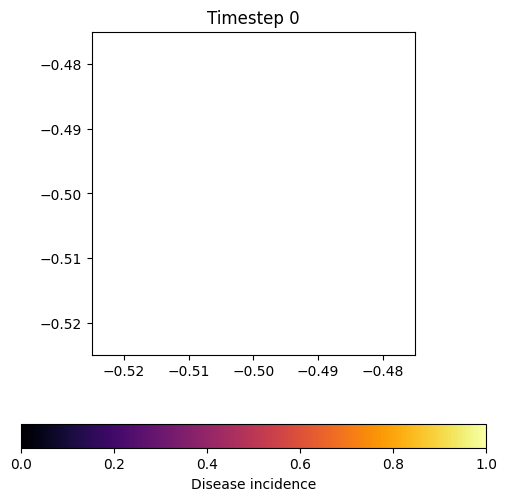

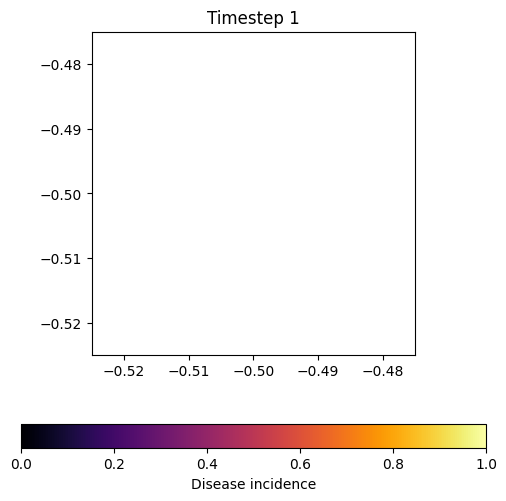

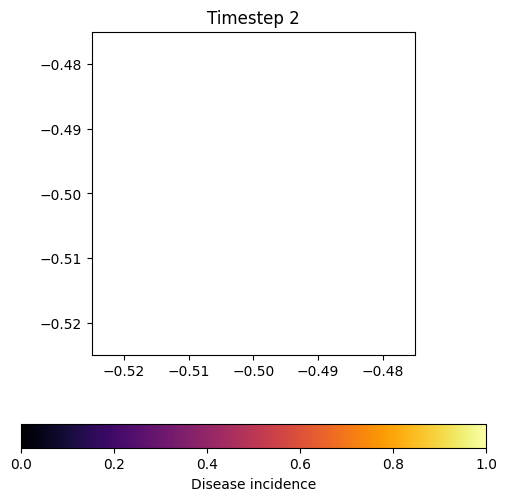

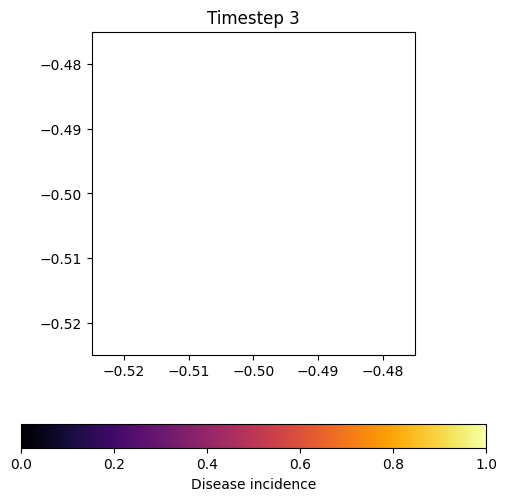

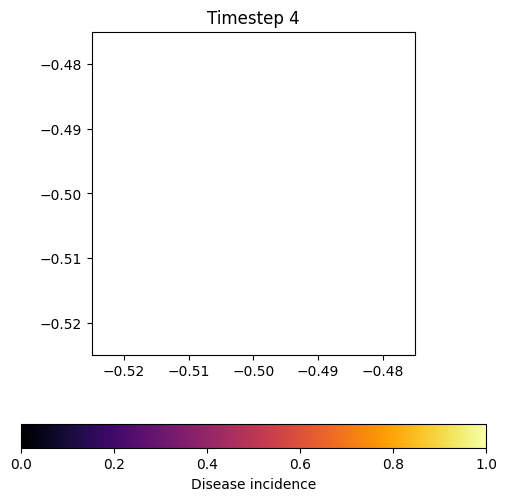

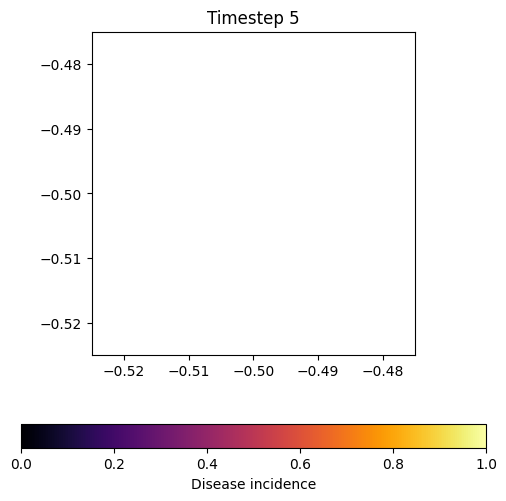

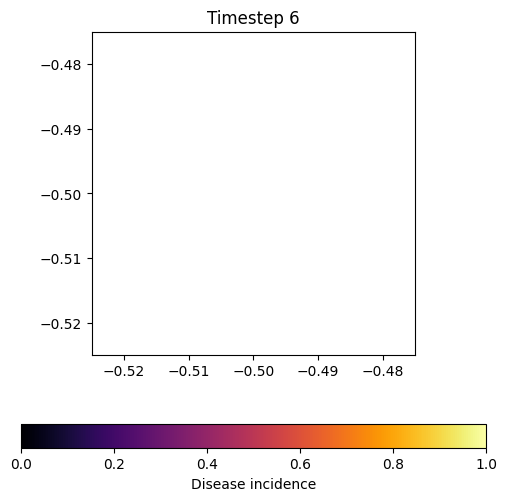

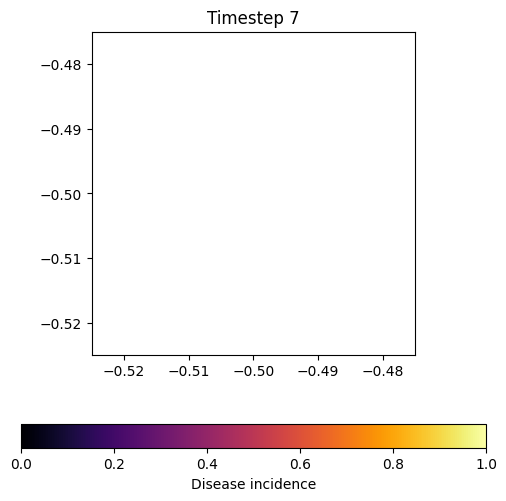

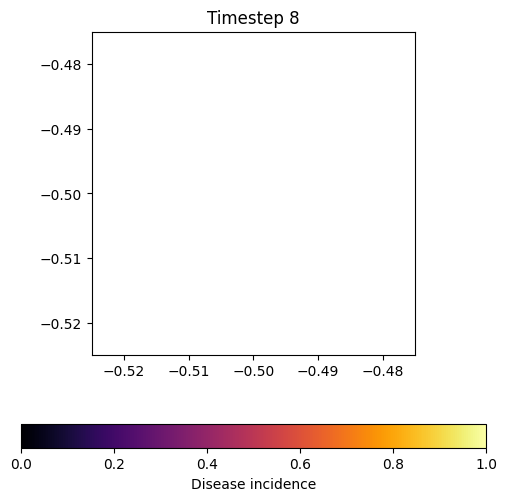

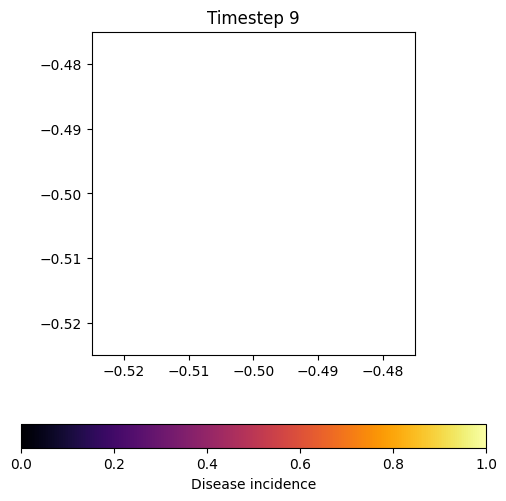

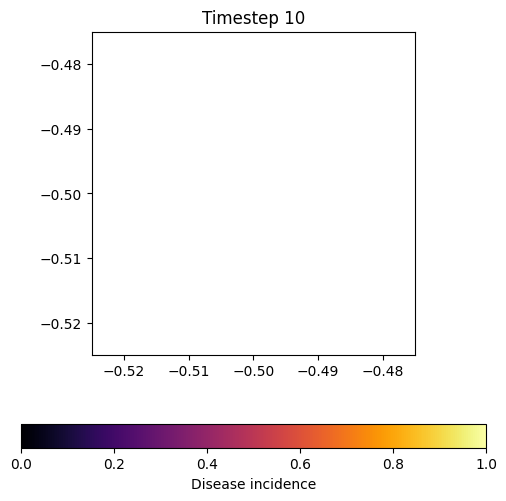

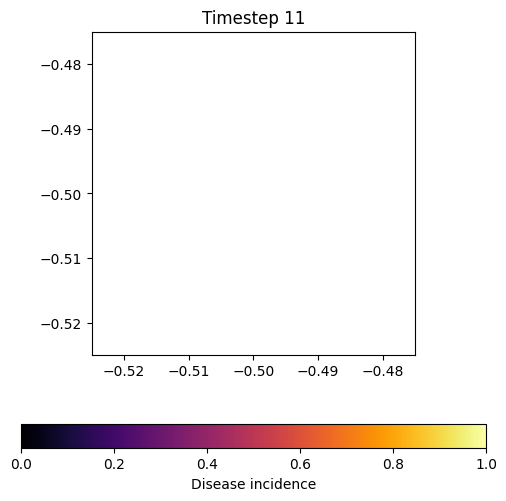

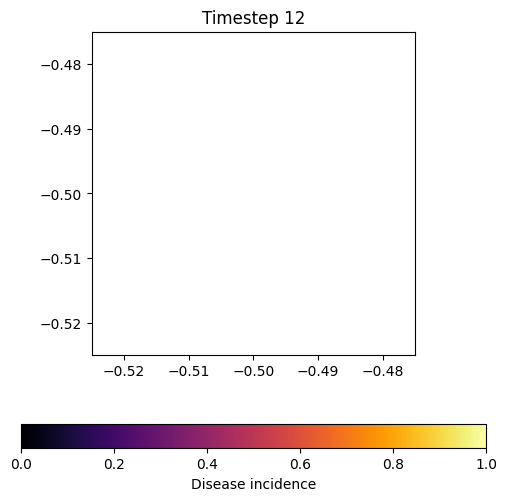

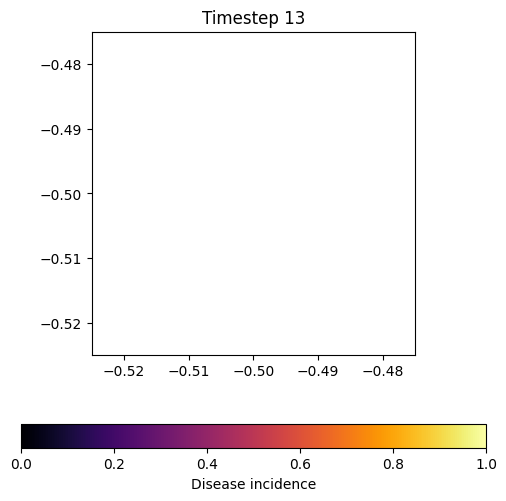

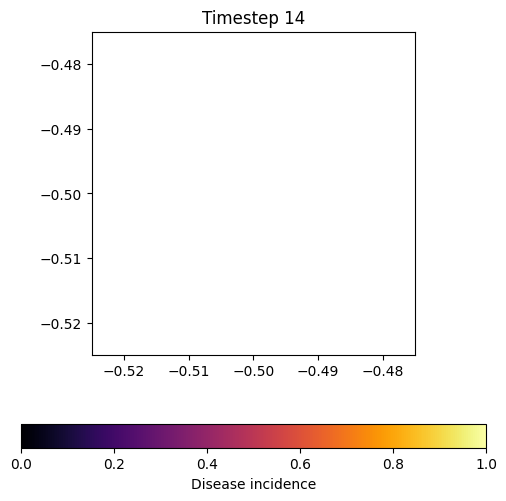

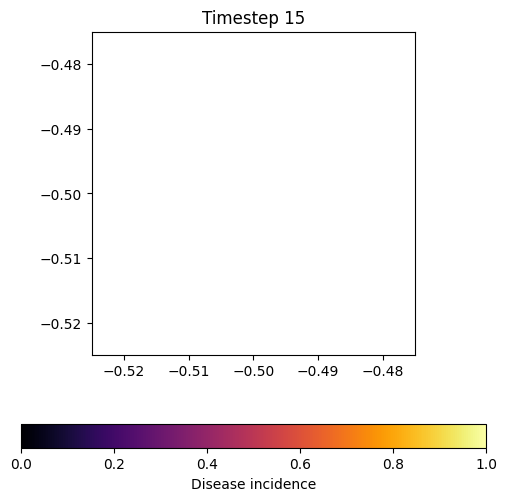

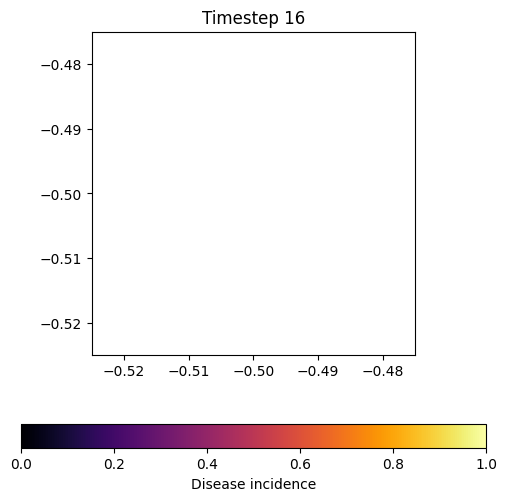

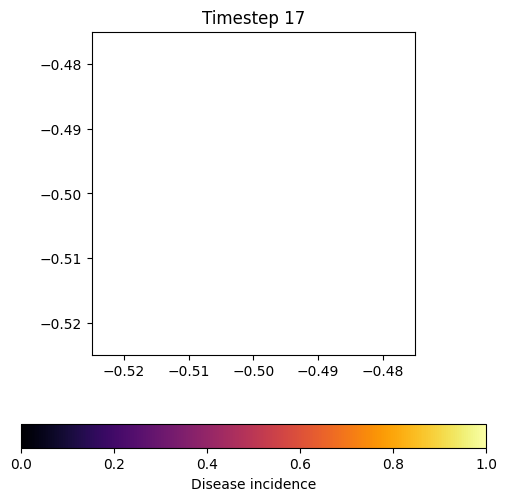

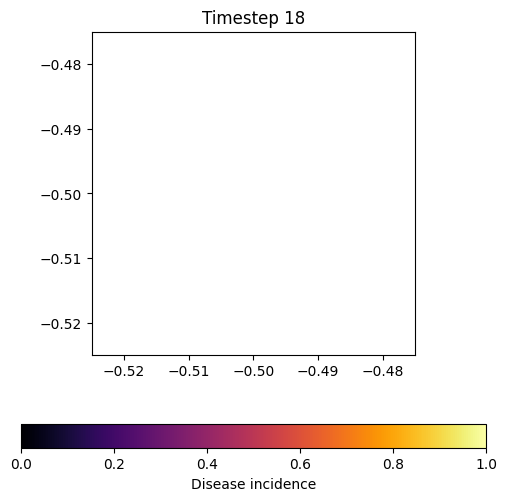

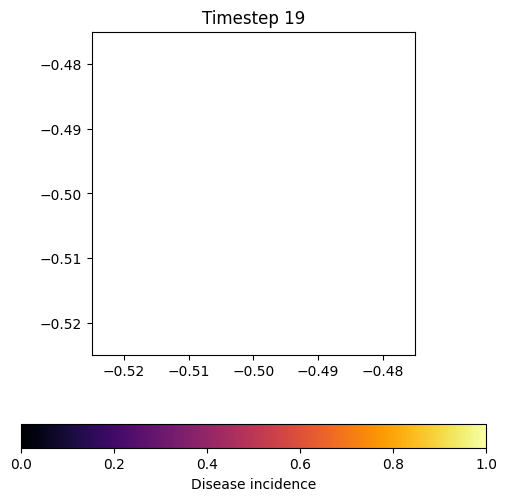

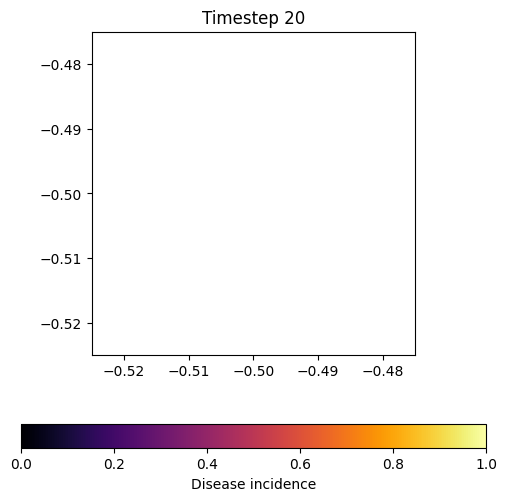

In [4]:
# RUN SIMULATION AND PLOT OUTCOME
np.random.seed(5)
timesteps = 20
GRID.simulate(timesteps, parameters)
GRID.plot_incidence(risk=False, zoom=True, final=False, figsize=(6,6))
# GRID.plot_incidence(risk=False, zoom=False, final=True, figsize=(6,6))
# GRID.plot_density(figsize=(6,6))

In [ ]:
# # PLOT KERNEL

# GRID.plot_short_distance_kernel(figsize=(8,8))

In [ ]:
# # EVALUATE RISK AND PLOT
# np.random.seed(5)
# N = 20
# timesteps = 10
# GRID.evaluate_risk(N, timesteps, parameters, verbose=False)
# # GRID.plot_incidence(risk=True, zoom=True, final=False, figsize=(6,6))
# # GRID.plot_incidence(risk=True, zoom=False, final=True, figsize=(6,6))

In [ ]:
# # PLOT DISTANCES OVER TIME
# np.random.seed(5)
# USE_RISK = True
# timesteps = 10
# N = 30

# avg_distance = np.zeros(timesteps+1)
# max_distance = avg_distance.copy()
# weighted_distance = avg_distance.copy() # distance weighted by incidence in cell

# if USE_RISK: GRID.evaluate_risk(N, timesteps, parameters)
# else:        GRID.simulate(timesteps, parameters)

# for t in range(timesteps+1):
#     if USE_RISK: infected_mask = GRID.risk[t] > 0
#     else:        infected_mask = GRID.incidence[t] > 0
#     infected_coordinates = np.argwhere(infected_mask)
#     distances = np.linalg.norm(infected_coordinates - GRID.seed, axis=1)
#     avg_distance[t] = np.mean(distances)
#     max_distance[t] = np.max(distances)
#     weights = GRID.incidence[t][infected_mask].flatten()
#     weighted_distance[t] = (distances * weights).sum() / weights.sum()

# intro_year = 2008
# years = intro_year + np.arange(timesteps+1)
# X = years.reshape(-1,1)
# y = avg_distance

# model = linear_model.LinearRegression()
# model.fit(X, y)

# y_pred = model.predict(X)
# coef = model.coef_[0]

# fig, ax = plt.subplots(figsize=(6,6))
# ax.plot(years, avg_distance, marker='o', linestyle='-', color='b', label='Average distance')
# ax.plot(years, y_pred, color='purple', linewidth=2, label=f'Spread rate = {np.round(coef,2)}km/year')
# ax.plot(years, max_distance, marker='o', linestyle='-', color='r', label='Maximum distance')
# ax.plot(years, weighted_distance, marker='o', linestyle='-', color='darkgreen', label='Weighted distance')
# ax.set_title('Distances from Gallipoli epicentre')
# ax.set_xlabel('Year')
# ax.set_xticks(years)
# ax.set_xticklabels(years, rotation=45)
# ax.set_ylabel('Distance (km)')
# ax.set_title('Distance from Epicentre Over Time')
# ax.grid(True)
# ax.legend()
# plt.tight_layout()
# plt.show()

# No control measures

## Calculate speed and compare different cases (risk, no risk, weighted, unweighted)

In [ ]:
# # CALCULATE SPEED

# np.random.seed(5)
# N = 100
# timesteps = 10

# model = GRID.calculate_speed(timesteps, parameters, N=N, use_risk=False, weighted=False, verbose=False)
# model_risk = GRID.calculate_speed(timesteps, parameters, N=N, use_risk=True, weighted=False, verbose=False)
# model_weight = GRID.calculate_speed(timesteps, parameters, N=N, use_risk=False, weighted=True, verbose=False)
# model_risk_weight = GRID.calculate_speed(timesteps, parameters, N=N, use_risk=True, weighted=True, verbose=False)

# print(f'Speed from 1 run (incidence): \nc = {np.round(model.params[0],1)}±{np.round(model.bse[0],1)}km/year\n')
# print(f'Speed from {N} runs (risk): \nc = {np.round(model_risk.params[0],1)}±{np.round(model.bse[0],1)}km/year\n')
# print(f'Speed from 1 run with weight (incidence): \nc = {np.round(model_weight.params[0],1)}±{np.round(model.bse[0],1)}km/year\n')
# print(f'Speed from {N} runs with weight (risk): \nc = {np.round(model_risk_weight.params[0],1)}±{np.round(model.bse[0],1)}km/year\n')

In [ ]:
# RESULTS
# Speed from 1 run (incidence): 
# c = 4.4±0.1km/year
# Speed from 100 runs (risk): 
# c = 6.8±0.1km/year
# Speed from 1 run with weight (incidence): 
# c = 3.3±0.1km/year
# Speed from 100 runs with weight (risk): 
# c = 3.5±0.1km/year

## Visualize local growth for varying parameters

In [ ]:
# np.random.seed(5)
# timesteps = 4

# A_list = np.arange(1, 8, 1)
# fig, ax = plt.subplots(figsize=(6,6))

# for A_trial in A_list:
#     parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                 'common': [A_trial, B, a, tol],
#                 'dispersal': [dispersal_type],
#                 'short_long': [beta, kernel_type, disp_tol, M_max, D],
#                 'levy_flight': [d_min, d_max, alpha]}
#     GRID.simulate(timesteps, parameters)
#     times = np.arange(timesteps+1)
#     local_growth = [GRID.incidence[t][tuple(GRID.seed)] for t in times]
#     ax.plot(times, local_growth, marker='o', linestyle='-', label=f'A = {A_trial}')
# ax.set_xlabel('Years after infection')
# ax.set_ylabel('Proportion infected')
# ax.set_xticks(times)
# plt.legend()
# plt.savefig('Images/Local_growth_A.png')
# plt.show()

## Sensitivity Analysis

In [ ]:
# # Global parameters
# N = 30
# timesteps = 8

### A: rate of local growth

In [ ]:
# np.random.seed(5)
# A_list = np.arange(0.5, 10, 0.5)
# A_model_list = []

# for i, A_trial in enumerate(A_list):
#     print(f'Parameter {i+1}/{len(A_list)}: A = {A_trial}')
#     parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                 'common': [A_trial, B, a, tol],
#                 'dispersal': [dispersal_type],
#                 'short_long': [beta, kernel_type, disp_tol, M_max, D],
#                 'levy_flight': [d_min, d_max, alpha]}
#     A_model_list.append(GRID.calculate_speed(timesteps, parameters, N=N, use_risk=True, weighted=True, verbose=False))

In [ ]:
# # PLOT A
# speed_list = [model.params for model in A_model_list]
# err_list = [model.bse for model in A_model_list]

# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(A_list, speed_list, marker='o', linestyle='-')
# ax.set_title(f'Weighted speed vs values of A (with risk calculated over {N} runs)')
# ax.set_xlabel('Value of A')
# ax.set_ylabel('Disease spreading speed (km/year)')
# plt.savefig('Images/Speed_A.png')
# plt.show()

### B: (related to) initial proportion of infected

In [ ]:
# np.random.seed(5)
# B_list = np.arange(1, 20, 1)
# B_model_list = []

# for i, B_trial in enumerate(B_list):
#     print(f'Parameter {i+1}/{len(B_list)}: B = {B_trial}')
#     parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                 'common': [A, B_trial, a, tol],
#                 'dispersal': [dispersal_type],
#                 'short_long': [beta, kernel_type, disp_tol, M_max, D],
#                 'levy_flight': [d_min, d_max, alpha]}
#     B_model_list.append(GRID.calculate_speed(timesteps, parameters, N=N, use_risk=True, weighted=True, verbose=False))

In [ ]:
# # PLOT B
# speed_list = [model.params for model in B_model_list]
# err_list = [model.bse for model in B_model_list]

# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(B_list, speed_list, marker='o', linestyle='-')
# ax.set_title(f'Weighted speed vs values of B (with risk calculated over {N} runs)')
# ax.set_xlabel('Value of B')
# ax.set_ylabel('Disease spreading speed (km/year)')
# plt.savefig('Images/Speed_B.png')
# plt.show()

### A and B simultaneously

In [ ]:
# step_A = 1
# A_list = np.arange(0.5, 8, step_A)
# step_B = 3
# B_list = np.arange(1, 20, step_B)

# model_list = []
# for i, A_trial in enumerate(A_list):
#     B_model_list = []
#     for j, B_trial in enumerate(B_list):
#         print(f'Parameter {i+1}/{len(A_list)} (A = {A_trial}), {j+1}/{len(B_list)} (B = {B_trial})')
#         parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                     'common': [A_trial, B_trial, a, tol],
#                     'dispersal': [dispersal_type],
#                     'short_long': [beta, kernel_type, disp_tol, M_max, D],
#                     'levy_flight': [d_min, d_max, alpha]}
#         B_model_list.append(GRID.calculate_speed(timesteps, parameters, N=N, use_risk=True, weighted=True, verbose=False))
#     model_list.append(B_model_list)

In [ ]:
# # PLOT A vs B
# speed_list = [[model.params for model in B_model_list] for B_model_list in model_list]
# err_list = [[model.bse for model in B_model_list] for B_model_list in model_list]

# fig, ax = plt.subplots(figsize=(8,8))
# im = ax.imshow(speed_list, cmap=plt.cm.Reds, extent=[np.min(B_list)-step_B/2, np.max(B_list)+step_B/2, np.min(A_list)-step_A/2, np.max(A_list)+step_A/2], origin='lower', norm=colors.Normalize(vmin=0, vmax=np.max(speed_list)+1))
# ax.set_aspect('auto')
# ax.set_title('Speed as a function of A and B')
# cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
# cbar.set_label('Speed (km/year)')
# ax.set_xlabel('B')
# ax.set_xticks(B_list)
# ax.set_ylabel('A')
# ax.set_yticks(A_list)
# plt.savefig('Images/Speed_AB.png')
# plt.show()

### Beta: mean dispersal distance (short-distance kernel) 

In [ ]:
# np.random.seed(5)
# beta_list = np.hstack((np.arange(0.05, 0.4, 0.05), np.arange(0.4, 1.1, 0.1))) 
# beta_model_list = []

# for i, beta_trial in enumerate(beta_list):
#     print(f'Parameter {i+1}/{len(beta_list)}: beta = {beta_trial}')
#     parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                 'common': [A, B, a, tol],
#                 'dispersal': [dispersal_type],
#                 'short_long': [beta_trial, kernel_type, disp_tol, M_max, D],
#                 'levy_flight': [d_min, d_max, alpha]}
#     beta_model_list.append(GRID.calculate_speed(timesteps, parameters, N=N, use_risk=True, weighted=True, verbose=False))

In [ ]:
# # PLOT beta
# speed_list = [model.params for model in beta_model_list]
# err_list = [model.bse for model in beta_model_list]

# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(beta_list, speed_list, marker='o', linestyle='-')
# ax.set_title(f'Weighted speed vs values of beta (with risk calculated over {N} runs)')
# ax.set_xlabel('Value of beta')
# ax.set_ylabel('Disease spreading speed (km/year)')
# plt.savefig('Images/Speed_beta.png')
# plt.show()

### $M_{max}$: maximum number of long-distance dispersers

In [ ]:
# np.random.seed(5)
# N_M_max = 30
# M_max_list = np.arange(2, 30, 5)
# M_max_model_list = []

# for i, M_max_trial in enumerate(M_max_list):
#     print(f'Parameter {i+1}/{len(M_max_list)}: M_max = {M_max_trial}')
#     parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                 'common': [A, B, a, tol],
#                 'dispersal': [dispersal_type],
#                 'short_long': [beta, kernel_type, disp_tol, M_max_trial, D],
#                 'levy_flight': [d_min, d_max, alpha]}
#     M_max_model_list.append(GRID.calculate_speed(timesteps, parameters, N=N_M_max, use_risk=True, weighted=True, verbose=False))

In [ ]:
# # PLOT M_max
# speed_list = [model.params for model in M_max_model_list]
# err_list = [model.bse for model in M_max_model_list]

# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(M_max_list, speed_list, marker='o', linestyle='-')
# ax.set_title(f'Weighted speed vs values of M_max (with risk calculated over {N_M_max} runs)')
# ax.set_xlabel('Value of M_max')
# ax.set_ylabel('Disease spreading speed (km/year)')
# plt.savefig('Images/Speed_M_max_30.png')
# plt.show()

### D: long-distance dispersal variance

In [ ]:
# np.random.seed(5)
# N_D = 30
# D_list = np.arange(5, 31, 2.5)
# D_model_list = []

# for i, D_trial in enumerate(D_list):
#     print(f'Parameter {i+1}/{len(D_list)}: D = {D_trial}')
#     parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                 'common': [A, B, a, tol],
#                 'dispersal': [dispersal_type],
#                 'short_long': [beta, kernel_type, disp_tol, M_max, D_trial],
#                 'levy_flight': [d_min, d_max, alpha]}
#     D_model_list.append(GRID.calculate_speed(timesteps, parameters, N=N_D, use_risk=True, weighted=True, verbose=False))

In [ ]:
# # PLOT D
# speed_list = [model.params for model in D_model_list]
# err_list = [model.bse for model in D_model_list]

# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(D_list, speed_list, marker='o', linestyle='-')
# ax.set_title(f'Weighted speed vs values of D (with risk calculated over {N_D} runs)')
# ax.set_xlabel('Value of D')
# ax.set_ylabel('Disease spreading speed (km/year)')
# plt.savefig('Images/Speed_D.png')
# plt.show()

### $M_{max}$ and D simultaneously

In [ ]:
# N_sim = 10
# step_M_max = 5
# M_max_list = np.arange(2, 28, step_M_max)
# step_D = 10
# D_list = np.arange(5, 36, step_D)

# model_list = []
# for i, M_max_trial in enumerate(M_max_list):
#     D_model_list = []
#     for j, D_trial in enumerate(D_list):
#         print(f'Parameter {i+1}/{len(M_max_list)} (M_max = {M_max_trial}), {j+1}/{len(D_list)} (D = {D_trial})')
#         parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                     'common': [A, B, a, tol],
#                     'dispersal': [dispersal_type],
#                     'short_long': [beta, kernel_type, disp_tol, M_max_trial, D_trial],
#                     'levy_flight': [d_min, d_max, alpha]}
#         D_model_list.append(GRID.calculate_speed(timesteps, parameters, N=N_sim, use_risk=True, weighted=True, verbose=False))
#     model_list.append(D_model_list)

In [ ]:
# # PLOT M_max vs D
# speed_list = [[model.params for model in D_model_list] for D_model_list in model_list]
# err_list = [[model.bse for model in D_model_list] for D_model_list in model_list]

# fig, ax = plt.subplots(figsize=(8,8))
# im = ax.imshow(speed_list, cmap=plt.cm.Reds, extent=[np.min(D_list)-step_D/2, np.max(D_list)+step_D/2, np.min(M_max_list)-step_M_max/2, np.max(M_max_list)+step_M_max/2], origin='lower', norm=colors.Normalize(vmin=0, vmax=np.max(speed_list)+1))
# ax.set_aspect('auto')
# ax.set_title('Speed as a function of M_max and D')
# cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
# cbar.set_label('Speed (km/year)')
# ax.set_xlabel('D')
# ax.set_xticks(D_list)
# ax.set_ylabel('M_max')
# ax.set_yticks(M_max_list)
# plt.savefig('Images/Speed_M_maxD.png')
# plt.show()

## Search for parameters

In [ ]:
# # Brute search
# c_mean = 6.5
# N_search = 10

# def model_speed(params):
#     A_, beta_, D_ = params
#     parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                   'common': [A_, B, a, tol],
#                   'dispersal': [dispersal_type],
#                   'short_long': [beta_, kernel_type, disp_tol, M_max, D_],
#                   'levy_flight': [d_min, d_max, alpha]}
#     model = GRID.calculate_speed(timesteps, parameters, N=N_search, use_risk=True, weighted=True, verbose=False)
#     speed = model.params[0]
#     return speed

# def residual_function(params):
#     speed = model_speed(params)
#     residuals = (speed - c_mean)**2
#     return residuals

In [ ]:
# A_range = np.arange(2, 4, 0.5) # np.arange(2, 2.5, 0.5)
# beta_range = np.arange(0.1, 0.3, 0.1) # np.arange(0.1, 0.15, 0.05)
# D_range = np.arange(15, 45, 5) # np.arange(5, 7.5, 2.5)

# params_list = []
# results_list = []
# speed_list = []

# n_iter = len(A_range) * len(beta_range) * len(D_range)
# i = 0
# for A_ in A_range:
#     for beta_ in beta_range:
#         for D_ in D_range:
#             i += 1
#             params = [A_, beta_, D_]
#             params_list.append(params)
#             print(f'Iteration {i}/{n_iter}: [A, beta, D] = {params}')
            
#             speed = model_speed(params)
#             speed_list.append(speed)
            
#             result = (speed - c_mean)**2
#             results_list.append(result)
#             print(result,'\n')

In [ ]:
# indices = list(np.where(np.array(results_list) < 1)[0])
# for i in indices:
#     print(params_list[i], results_list[i], speed_list[i])

# optimized_parameters = params_list[np.where(np.array(results_list) == np.min(results_list))[0][0]]
# print(optimized_parameters)

In [ ]:
# A_, beta_, D_ = optimized_parameters
# parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#               'common': [A_, B, a, tol],
#               'dispersal': [dispersal_type],
#               'short_long': [beta_, kernel_type, disp_tol, M_max, D_],
#               'levy_flight': [d_min, d_max, alpha]}

# model = GRID.calculate_speed(timesteps, parameters, N=N, use_risk=True, weighted=True, verbose=True)
# speed = model.params[0]
# print(speed)

# Control measures

In [ ]:
# SIMULATION PARAMETERS
# Control zone parameters
control = True
EZW = 20
BZW = 10
EZ_eff = 1
BZ_eff = 0.9

# Common parameters
A = 3 # 3 kp rate of local population growth
B = 14.069
a = 0 # relative carrying capacity in non olive plants
tol = 1e-8 # 1e-8 numerical noise tolerance (IF TOLERANCE IS TOO BIG, IT CAN HAPPEN THAT THE SIMULATION IS TRUNCATED AT THE FIRST ITERATION)

# Dispersal type
dispersal_type = "short_long" # short_long, levy_flight

# Short distance kernel
beta = 0.2 # 0.1
kernel_type = "exponential"

# Long distance kernel
disp_tol = 0.2 # 0.2 strattol stratified dispersal tolerance (threshold probability)
M_max = 5 # 5 maximum number of dispersers
D = 35 # 20 dispersal standard deviation

# Power law kernel (Levy flight)
d_min = 0.1
d_max = 20 # None
alpha = 7

# Define parameter dictionary (to be fed to .simulate())
parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
              'common': [A, B, a, tol],
              'dispersal': [dispersal_type],
              'short_long': [beta, kernel_type, disp_tol, M_max, D],
              'levy_flight': [d_min, d_max, alpha]}

In [ ]:
# RUN SIMULATION AND PLOT OUTCOME
np.random.seed(5)
timesteps = 20
GRID.simulate(timesteps, parameters)
GRID.plot_incidence(risk=False, zoom=True, final=False, figsize=(6,6))
# GRID.plot_incidence(risk=False, zoom=False, final=True, figsize=(6,6))

# Other

In [ ]:
# # D: long-range dispersal 
# np.random.seed(5)
# D_list = 2.5 + 2.5 * np.arange(15)
# D_model_list = []

# for i, D_trial in enumerate(D_list):
#     print(f'Parameter {i+1}/{len(D_list)}: D = {D_trial}')
#     parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                 'common': [A, B, a, tol],
#                 'dispersal': [dispersal_type],
#                 'short_long': [beta, kernel_type, disp_tol, M_max, D_trial],
#                 'levy_flight': [d_min, d_max, alpha]}
#     D_model_list.append(GRID.calculate_speed(timesteps, parameters, N=N, use_risk=True, weighted=True, verbose=False))

In [ ]:
# speed_list = [model.params for model in D_model_list]
# err_list = [model.bse for model in D_model_list]

# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(D_list, speed_list)
# plt.show()

In [ ]:
# # beta_list
# # disp_tol_list = 
# M_max_list = [4, 5, 6, 7, 8] 
# D_list = [10, 20, 30]

# speed_list = []
# for D in D_list:
#     for M_max in M_max_list:
#         parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                     'common': [A, B, a, tol],
#                     'dispersal': [dispersal_type],
#                     'short_long': [beta, kernel_type, disp_tol, M_max, D],
#                     'levy_flight': [d_min, d_max, alpha]}
#         print(f'D={D}, M_max={M_max}')
#         speed_list.append(GRID.calculate_speed(timesteps, parameters, N=N, use_risk=True, weighted=True))

# print(speed_list)

In [ ]:
# import numpy as np
# from scipy.optimize import least_squares

# # Observed speed of disease spread (example data)
# observed_speed = 9.75 # 17.8
# timesteps = 10

# def residuals(params):
#     A, B, beta, D = params
#     parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
#                   'common': [A, B, a, tol],
#                   'dispersal': [dispersal_type],
#                   'short_long': [beta, kernel_type, disp_tol, M_max, D],
#                   'levy_flight': [d_min, d_max, alpha]}
#     predicted_speed = calculate_speed(GRID, timesteps, parameters, use_risk=False)
#     return observed_speed - predicted_speed

# # Initial guess for the parameters
# initial_guess = np.array([3, 14.069, 0.1, 20])

# # Run the least squares optimization
# result = least_squares(residuals, initial_guess)#, bounds=(0, np.inf))

# # Output the optimal parameters
# optimal_params = result.x
# print("Optimal Parameters:", optimal_params)


In [ ]:
# CALCULATE SPEED OF SPREAD FROM AVERAGE DISTANCE
# 2013-2023: 9.75 km/year
# 2013-2016: 17.8 km/year

# Define a function from which calculating least squares. 
# Can do a grid search or through a "smarter" search



In [ ]:
# # EVALUATE RISK

# N = 5
# timesteps = 10
# GRID.evaluate_risk(N, timesteps, parameters)

In [ ]:
# # PLOT RISK AT DIFFERENT TIMES

# im_sea = np.ma.array(GRID.density, mask=~GRID.sea_mask)

# ncols = 5
# images = []
# fig, ax = plt.subplots(1, ncols, figsize=(ncols*4,4))
# for i in range(ncols):
#     images.append(ax[i].imshow(GRID.risk[1+2*i], cmap="inferno", interpolation=None, norm=colors.Normalize(vmin=0, vmax=1)))
#     ax[i].imshow(im_sea, cmap=colors.ListedColormap(['tab:blue']), interpolation=None)
#     ax[i].set_title(f"{1+2*i}-year risk")
# cbar = fig.colorbar(images[0], ax=ax, orientation="horizontal")
# cbar.set_label("Risk")

# plt.show()

In [ ]:
# # EVALUATE RISK (AVERAGE INCIDENCE) OVER GRID TIMESERIES
# # Short_long kernel with and without Control Zone

# average = np.zeros(GRID.timesteps+1)

# for t in range(GRID.timesteps+1):
#     average[t] = GRID.risk[t][GRID.grove_mask].mean()
    
# plt.plot(np.arange(GRID.timesteps+1), average)
# plt.show()

In [ ]:
# # PERCENTAGE OF GROVES THAT ARE INFECTED (ASSUMING 1 GROVE=1 GRID CELL)
# # The Gompertz growth model grows very quickly even extremely small numbers.
# # One year (one iteration) is typically enough to have a sizable value for I (incidence)
# # So I will coansider as infected, all those groves above the tolerance value 'tol'

# percentage_of_groves = np.zeros(GRID.incidence.shape[0])

# for t in range(GRID.timesteps+1):
#     percentage_of_groves[t] = len(GRID.incidence[t][GRID.incidence[t] > tol]) / len(GRID.grove_mask.flatten())

# plt.plot(np.arange(GRID.timesteps+1), percentage_of_groves)

# plt.show()

In [ ]:
# N = 2
# timesteps = 5

# # GRID.simulate(timesteps, parameters)
# GRID.evaluate_risk(N, timesteps, parameters)

# # print(GRID.incidence.shape)
# print(GRID.risk.shape)

In [ ]:
# # RUN SIMULATION FOR DIFFERENT PARAMETERS

# N = 10
# timesteps = 10
# EZW_list = [10, 20, 30]
# percentage_of_groves = np.zeros((len(EZW_list), GRID.timesteps+1))
# # print(percentage_of_groves.shape)

# for i, EZW in enumerate(EZW_list):
#     parameters = {'control_zone': [control, EZW, BZW, BZ_eff],
#                   'common': [A, B, a, tol],
#                   'dispersal': [dispersal_type],
#                   'short_long': [beta, kernel_type, disp_tol, M_max, D],
#                   'levy_flight': [n_vectors, d_min, d_max, alpha, sample]}

#     # GRID.simulate(timesteps, parameters)
#     GRID.evaluate_risk(N, timesteps, parameters)
#     # GRID.plot_density(figsize=(6,6))
#     # GRID.plot_final_incidence(figsize=(6,6))

#     for t in range(GRID.timesteps+1):
#         # percentage_of_groves[i,t] = len(GRID.incidence[t][GRID.incidence[t] > tol]) / len(GRID.grove_mask.flatten())
#         percentage_of_groves[i,t] = len(GRID.risk[t][GRID.risk[t] > tol]) / len(GRID.grove_mask.flatten())


In [ ]:
# # PLOT PERCENTAGE OF INFECTED GROVES FOR DIFFERENT PARAMETER VALUES

# for i, EZW in enumerate(EZW_list):
#     plt.plot(np.arange(GRID.timesteps+1), percentage_of_groves[i], label=f'EZW={EZW}')

# plt.legend(loc='upper right')
# plt.title(f"Percentage of infected groves (from {timesteps}-year risk) for different values of EZW")
# plt.show()

In [ ]:
# First interesting result: the size of the control zone determines a delay in the epidemic spread
# Explore different values for EZW and BZW
# Calculate time delay from simulation
# The increase in average incidence and percentage of infected groves increases linearly with time
# This reflects a constant speed for the infection front

# Differences in this regard between short_long and levy_flight. Levy_flight needs more time to 
# resume same pace (?): verify.  

In [ ]:
# INCLUDE VECTOR POPULATION DYNAMICS

In [ ]:
# EVALUATE SPEED OF EPIDEMIC SPREAD 

# Get the centroid of each grid cell. 
# Create distance classes:
# - 1 km radius around centroid of seed cell (includes all cells whose centroid is within the radius)
# - 1 km wide concentric rings around centroid of seed cell (same) 

In [ ]:
# add "scale" parameter for rescaling of random samples; resolved by simply modifying alpha exponent parameter


In [ ]:
# x = 280
# y = 230
# # print(np.mean(data))

# # plt.hist(data, bins=10)

# binwidth = 0.1

# for t in range(timesteps+1):
#     # flattened_data = GRID.I[t][GRID.I[t] > 0].flatten()
#     # flattened_data = GRID.incidence[t][(GRID.incidence[t] > 0.3) & (GRID.incidence[t] < 0.8)].flatten()
#     data = GRID.all_incidences[:,t,y,x]
#     (n, bins, patches) = plt.hist(data, bins=np.arange(0, 1 + binwidth, binwidth))
#     plt.xlim(0,1 + binwidth)
#     plt.show()
#     print(n)



In [ ]:
# def calculate_speed(grid, timesteps, parameters, N=None, use_risk=False, weighted=False):
#     avg_distance = np.zeros(timesteps+1)
#     max_distance = avg_distance.copy()
#     if weighted:
#         weighted_distance = avg_distance.copy() # distance weighted by incidence in cell

#     if use_risk: grid.evaluate_risk(N, timesteps, parameters)
#     else:        grid.simulate(timesteps, parameters)

#     for t in range(timesteps+1):
#         if use_risk: infected_mask = grid.risk[t] > 0
#         else:        infected_mask = grid.incidence[t] > 0
#         infected_coordinates = np.argwhere(infected_mask)
#         distances = np.linalg.norm(infected_coordinates - grid.seed, axis=1)
#         avg_distance[t] = np.mean(distances)
#         max_distance[t] = np.max(distances)
#         if weighted:
#             weights = grid.incidence[t][infected_mask].flatten()
#             weighted_distance[t] = (distances * weights).sum() / weights.sum()

#     X = np.arange(timesteps+1)
#     y = weighted_distance

#     # model = linear_model.LinearRegression(fit_intercept=False)
#     # model.fit(X.reshape(-1,1), y, )

#     ols = sm.OLS(y, X)
#     model = ols.fit()

#     return model

# np.random.seed(5)

# N = 3
# timesteps = 10
# model = calculate_speed(GRID, timesteps, parameters, N=N, use_risk=True, weighted=True)